# Model evaluations

In this notebook, we use the test set to cross compare the results of different models. 

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

In [3]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [4]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

## Importing the test samples

Since the test samples have not yet augmented at this point, here we perform the same augmentation process as we did for the training set. 

In [5]:
%%time 

data = np.load('samples/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

## augmenting grayscale images
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

## augmenting the colorful images
indx = esn_shuffle(np.arange(N_gri))
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

## half of the grayscale images are inverted
n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]

CPU times: user 8.07 s, sys: 1.19 s, total: 9.26 s
Wall time: 8.98 s


The test sample comprises ~3,300 samples after 

In [6]:
images_test_aug.shape, labels_test_aug.shape

((3314, 128, 128, 3), (3314,))

The following function takes the CNN model that outputs values that are between -1 and 1 and maps tnem to numbers between 45 and 90, the evaluated inclinations.

In [7]:
def predictor(model, img_arr):
  
    prediction = model.predict(img_arr)
    prediction = 0.5*(prediction+1.)*45.+45.
    prediction[(prediction > 90)] = 90
    
    return prediction

In three following cells we import different flavors of the trained models 4, 5, and 6.

Model names are in the form `model<n><m>`, where `<n>` is the model label which can be 4, 5, and 6. `<m>` denotes the flavor of the model, where `m=0` represents a model that has been trained using the entire training sample. $m\neq0$ stand for models that have been trained using $67\%$ of data.

In [8]:
import TFmodels

allModels = {}
myModel = []

ckpt_dir = "./U0_model04_ckpt/"
MODEL = TFmodels.model4()
MODEL.load_weights(ckpt_dir+"2999.ckpt")
myModel.append(("model40" , MODEL))

ckpt_dir = "./U1_model04_ckpt/"
MODEL = TFmodels.model4()
MODEL.load_weights(ckpt_dir+"1503.ckpt")
myModel.append(("model41" , MODEL))

ckpt_dir = "./U2_model04_ckpt/"
MODEL = TFmodels.model4()
MODEL.load_weights(ckpt_dir+"1800.ckpt")
myModel.append(("model42" , MODEL))

ckpt_dir = "./U3_model04_ckpt/"
MODEL = TFmodels.model4()
MODEL.load_weights(ckpt_dir+"1000.ckpt")
myModel.append(("model43" , MODEL))

allModels["model4"] = myModel

In [9]:
myModel = []

ckpt_dir = "./U0_model05_ckpt/"
MODEL = TFmodels.model5()
MODEL.load_weights(ckpt_dir+"700.ckpt")
myModel.append(("model5" , MODEL))

ckpt_dir = "./U1_model05_ckpt/"
MODEL = TFmodels.model5()
MODEL.load_weights(ckpt_dir+"700.ckpt")
myModel.append(("model51" , MODEL))

ckpt_dir = "./U2_model05_ckpt/"
MODEL = TFmodels.model5()
MODEL.load_weights(ckpt_dir+"700.ckpt")
myModel.append(("model52" , MODEL))

ckpt_dir = "./U3_model05_ckpt/"
MODEL = TFmodels.model5()
MODEL.load_weights(ckpt_dir+"700.ckpt")
myModel.append(("model53" , MODEL))

allModels["model5"] = myModel

In [10]:
myModel = []

ckpt_dir = "./U0_model06_ckpt/"
MODEL = TFmodels.model6()
MODEL.load_weights(ckpt_dir+"1200.ckpt")
myModel.append(("model6" , MODEL))

ckpt_dir = "./U1_model06_ckpt/"
MODEL = TFmodels.model6()
MODEL.load_weights(ckpt_dir+"1200.ckpt")
myModel.append(("model61" , MODEL))

ckpt_dir = "./U2_model06_ckpt/"
MODEL = TFmodels.model6()
MODEL.load_weights(ckpt_dir+"1200.ckpt")
myModel.append(("model62" , MODEL))

ckpt_dir = "./U3_model06_ckpt/"
MODEL = TFmodels.model6()
MODEL.load_weights(ckpt_dir+"1500.ckpt")
myModel.append(("model63" , MODEL))

allModels["model6"] = myModel

## Auxiliary functions to generate plots

In [11]:
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [37]:
def makePlot(ax, inc_m, inc_p, color='b'):

    d = inc_m-inc_p
    
    indx = (np.abs(d)<10)
    m, b = np.polyfit(inc_m[indx], d[indx], 1)
    x = np.linspace(50,90,20)
    y  = m*x+b

    ax.plot(inc_m, d, '.', color=color, alpha=0.2)
    ax.plot([0,100],[0,0], 'k:')
    ax.plot(x, y, 'r-')

    ax.text(50,-15, "RMS: %.2f deg"%np.sqrt(np.mean((d)**2)), fontsize=14)
    ax.text(50,-21, "MAE: %.2f deg"%np.mean(np.abs(d)), fontsize=14)

For better evaluating the performance of different models, we store all of their predictions in a Pandas data frame. 

In [19]:
data = {'pgc': pgcIDs_test_aug, 'filter':filter_test_aug, 'inc_m': labels_test_aug}
df = pd.DataFrame.from_dict(data)
df.head()

,pgc,filter,inc_m
0,23995,b'c',72
1,3630345,b'c',70
2,87316,b'c',74
3,23071,b'r',90
4,71590,b'c',69


For all models, we run the prediction functions of the same set of test galaxies and store the results in the data frame. We save the data frame in a `csv` file for later use, since the evaluation of all inclinations for all models takes a while.

In [20]:
# for i, mod in enumerate(["model4", "model5", "model6"]):
#     for j in range(4):
#         inc_p = predictor(allModels[mod][j][1], images_test_aug).reshape(-1)
#         df[mod+"_"+str(j)] = inc_p
        
#         print(mod, j)
        
# df.to_csv("model_evaluation.csv")

model4 0
model4 1
model4 2
model4 3
model5 0
model5 1
model5 2
model5 3
model6 0
model6 1
model6 2
model6 3


Loading the evaluations of various models.

In [29]:
df = pd.read_csv('model_evaluation.csv')
df = df[df.columns[1:]].set_index("pgc")
df.head()

,filter,inc_m,model4_0,model4_1,model4_2,model4_3,model5_0,model5_1,model5_2,model5_3,model6_0,model6_1,model6_2,model6_3
pgc,,,,,,,,,,,,,,
23995,b'c',72,70.282220,73.02544,71.715110,72.050100,69.134346,69.466835,69.085060,69.405624,72.015450,71.098470,68.557600,72.430740
3630345,b'c',70,69.479706,73.09889,70.312730,73.054726,70.445950,69.978424,69.537050,70.403690,69.864105,68.792694,67.288155,67.411026
87316,b'c',74,66.836680,69.85914,71.002365,65.971620,72.901886,69.312520,70.468170,69.589620,72.683670,71.430350,70.696860,68.712780
23071,b'r',90,89.554950,89.30301,89.846810,89.188250,89.926480,89.257100,89.597680,89.353340,89.845180,89.397340,89.928390,89.840030
71590,b'c',69,67.274140,67.73721,69.111360,71.465130,66.324110,64.421690,62.961105,72.364075,71.227295,69.765620,67.390470,68.792680


## Plots

Plotting prediction-measurement($\Delta i-i_m-i_p$) vs. measurements. In the following figure, the horizontal axis shows the measured inclinations. Each point represents a galaxy in the test sample. 

In almost all cases the prediction bias is at minimum and not that significant. Each panel displays the results of a model, and is labeled with the name of the corresponding model.  

At first glance, Model #5 has the best performance, which does not come as surprise since it is the most complicated model that we considered. In general, the difference in the performance of the model is not that significant. 

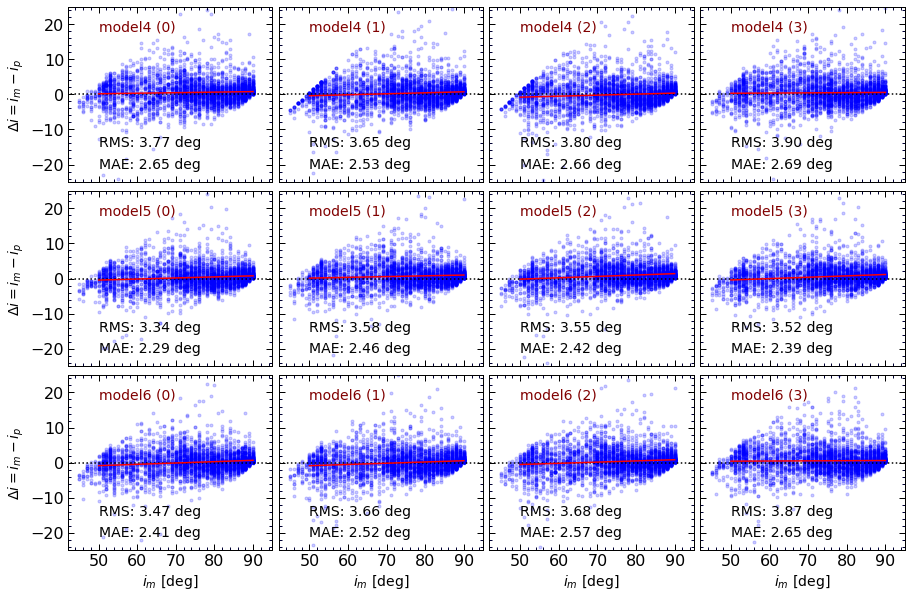

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10)) 

for i, mod in enumerate(["model4", "model5", "model6"]):
    
    for j in range(4):
    
        ax = axes[i][j]
        makePlot(ax, df["inc_m"], df[mod+"_"+str(j)])
        set_axes(ax, (42,95), (-25,25))
        
        if j!=0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)
        if i==2:
            ax.set_xlabel(r'$i_m$'+ ' [deg]', fontsize=14)
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        ax.text(50, 18, mod + ' (%d)'%j, fontsize=14, color='maroon')

plt.subplots_adjust(hspace=0.05, wspace=0.03)

## Average models

We take two average types to combine the results of various models and possibly obtain better results

- median
- mean

We generate 4 sets of averages

- averaging the results of all model4 flavors
- averaging the results of all model5 flavors
- averaging the results of all model6 flavors
- averaging the results of all models with various flavors

We don't see any significant differences between `mean` and `median`, so there is not way we prefer one of them. However, we recommend using the median just to ignore very severe outliers.

### The power of bagging

Clearly, when the results of all models are averaged out, we get the best performance. RMS and MAE of deviations of the all models average from the measured values are 3.09 and 2.12 [deg], respectively.

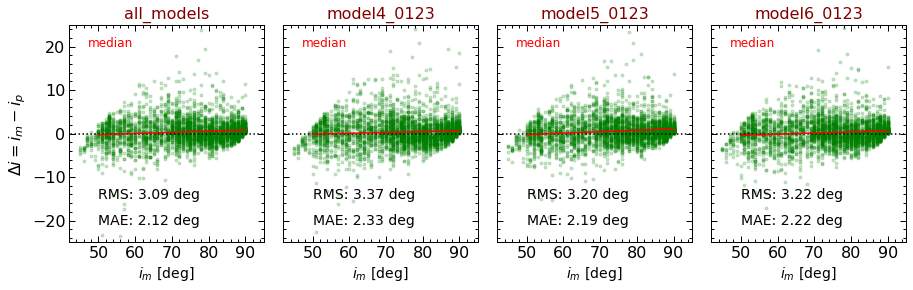

In [54]:
## taking median or average
model4_list = ["model4_"+str(i) for i in range(4)]
df["model4_0123"] = df[model4_list].median(axis=1)

model5_list = ["model5_"+str(i) for i in range(4)]
df["model5_0123"] = df[model5_list].median(axis=1)

model6_list = ["model6_"+str(i) for i in range(4)]
df["model6_0123"] = df[model6_list].median(axis=1)

df["all_models"] = df[model4_list+model5_list+model6_list].median(axis=1)

## plotting section
#######################################################################
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4)) 

for i, mod in enumerate(["all_models"]+["model"+j+"_0123" for j in ['4','5', '6']]):
    ax = axes[i]
    makePlot(ax, df["inc_m"], df[mod], color='g')
    set_axes(ax, (42,95), (-25,25))
    
    if i==0:
        ax.set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=16)
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel(r'$i_m$'+ ' [deg]', fontsize=14)
    ax.set_title(mod, color='maroon', fontsize=16)
    ax.text(47,20, 'median', color='red', fontsize=12)

plt.subplots_adjust(hspace=0.1, wspace=0.1)

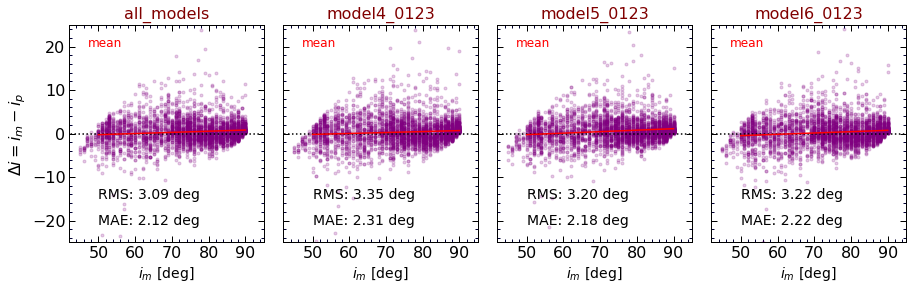

In [55]:
## taking median or average
model4_list = ["model4_"+str(i) for i in range(4)]
df["model4_0123"] = df[model4_list].mean(axis=1)

model5_list = ["model5_"+str(i) for i in range(4)]
df["model5_0123"] = df[model5_list].mean(axis=1)

model6_list = ["model6_"+str(i) for i in range(4)]
df["model6_0123"] = df[model6_list].mean(axis=1)

df["all_models"] = df[model4_list+model5_list+model6_list].median(axis=1)

## plotting section
#######################################################################
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4)) 

for i, mod in enumerate(["all_models"]+["model"+j+"_0123" for j in ['4','5', '6']]):
    ax = axes[i]
    makePlot(ax, df["inc_m"], df[mod], color='purple')
    set_axes(ax, (42,95), (-25,25))
    
    if i==0:
        ax.set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=16)
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel(r'$i_m$'+ ' [deg]', fontsize=14)
    ax.set_title(mod, color='maroon', fontsize=16)
    ax.text(47,20, 'mean', color='red', fontsize=12)

plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Evaluation of the binary classification models

## importing the test sample for binary classification

We also take the same augmentation approach.

In [57]:
%%time 

data = np.load('samples_binary/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

## augmenting grayscale images
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

## augmenting the colorful images
indx = esn_shuffle(np.arange(N_gri))
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

## half of the grayscale images are inverted
n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]

CPU times: user 11 s, sys: 2.38 s, total: 13.4 s
Wall time: 12.9 s


### We reject galaxies whose rejection likelihood is larger than 50%

In [58]:
def predictor_binary(model, img_arr, alfa=0.5):
  
    prediction = model.predict(img_arr)
    prediction = prediction[:,1]
    prediction[(prediction<=alfa)] = 0  # accepted
    prediction[(prediction> alfa)] = 1  # rejected

    return prediction

In [65]:
import TFmodels

allModels_binary = []

ckpt_dir = "./U0_model04_binary_ckpt/"
MODEL = TFmodels.model4(n_classes = 2)
MODEL.load_weights(ckpt_dir+"200.ckpt")
allModels_binary.append(("model4-binary" , MODEL))

ckpt_dir = "./U0_model05_binary_ckpt/"
MODEL = TFmodels.model5(n_classes = 2)
MODEL.load_weights(ckpt_dir+"200.ckpt")
allModels_binary.append(("model5-binary" , MODEL))

ckpt_dir = "./U0_model06_binary_ckpt/"
MODEL = TFmodels.model6(n_classes = 2)
MODEL.load_weights(ckpt_dir+"200.ckpt")
allModels_binary.append(("model6-binary" , MODEL))

In [66]:
data = {'pgc': pgcIDs_test_aug, 'filter':filter_test_aug, 'label_m': labels_test_aug}
df = pd.DataFrame.from_dict(data)
df.head()

,pgc,filter,label_m
0,68156,b'c',1
1,3575,b'c',1
2,10303,b'c',0
3,29507,b'r',0
4,44370,b'r',0


## Applying the classification models on the test data

We save the prediction results for the later use.

In [67]:
# for j in range(3):
#     label = predictor_binary(allModels_binary[j][1], images_test_aug).reshape(-1)
#     df[allModels_binary[j][0]] = label

#     print(allModels_binary[j][0], j)
        
# df.to_csv("model_evaluation_binary.csv")

model4-binary 0
model5-binary 1
model6-binary 2


### Recovering the outputs 

In [70]:
df = pd.read_csv('model_evaluation_binary.csv')
df = df[df.columns[1:]].set_index('pgc')
df.head()

,filter,label_m,model4-binary,model5-binary,model6-binary
pgc,,,,,
68156,b'c',1,1.0,1.0,1.0
3575,b'c',1,1.0,1.0,1.0
10303,b'c',0,1.0,0.0,1.0
29507,b'r',0,0.0,0.0,0.0
44370,b'r',0,0.0,0.0,0.0


Taking the mean and median of all models evaluations.

In [105]:
cols = ['model4-binary','model5-binary','model6-binary']
df['ave'] = df[cols].mean(axis=1)
df['mean'] = df.apply(lambda x: 1 if x.ave>0.5 else 0, axis=1)
df['median'] = df[cols].median(axis=1)

A function to calculate the well-known classification metrics

In [81]:
def classification_metrics(df, true_labels='label_m', predicted_labels='model4-binary'):
    
    ## true positive
    TP = len(df[((df[true_labels]==1)&(df[predicted_labels]==1))])
    
    ## false positive
    FP = len(df[((df[true_labels]==0)&(df[predicted_labels]==1))])
    
    ## true negative
    TN = len(df[((df[true_labels]==0)&(df[predicted_labels]==0))])
    
    ## false negative
    FN = len(df[((df[true_labels]==1)&(df[predicted_labels]==0))])  
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    return [precision, recall, accuracy], [TP, FP, TN, FN]

### Visualizing the classification metrics ...

... for different models.

Evidently, model #5 has a better overall performance compared to the other two models, which does not come as surprise knowing that model #5 is the most complicated one.

Averaging out the evaluated labels does make some improvements, however model #5 seems to perform slightly better than the average.

[Text(0, 0, 'precision'), Text(0, 0, 'recall'), Text(0, 0, 'accuracy')]

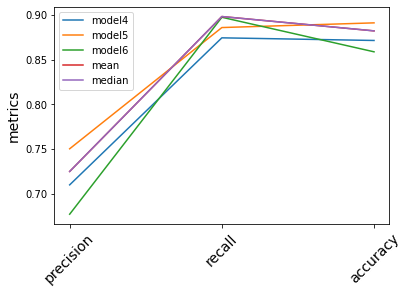

In [106]:
fig, ax = plt.subplots(1,1)

x = np.arange(3)

for j in ['4','5','6']:
    metrics, _ = classification_metrics(df, predicted_labels='model'+j+'-binary')
    ax.plot(x, metrics, label='model'+j)
    
metrics, _ = classification_metrics(df, predicted_labels='mean')
ax.plot(x, metrics, label='mean')

metrics, _ = classification_metrics(df, predicted_labels='median')
ax.plot(x, metrics, label='median')

ax.set_ylabel('metrics', fontsize=14)
ax.set_xlabel('')

ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(['precision', 'recall', 'accuracy'], minor=False, rotation=45, fontsize=14)